In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go

In [13]:
import os
import io
import zipfile
from datetime import date
import requests
from tqdm import tqdm

DATA_DIR = "data"
KLINE_COLUMNS = [
    "open_time",         # 0
    "open",              # 1
    "high",              # 2
    "low",               # 3
    "close",             # 4
    "volume",            # 5
    "close_time",        # 6
    "quote_asset_volume",# 7
    "number_of_trades",  # 8
    "taker_buy_base",    # 9
    "taker_buy_quote",   # 10
    "ignore"             # 11
]

def month_range(start_year=2020, start_month=1):
    """Yield (year, month) from start up to previous month."""
    today = date.today()
    end_y, end_m = today.year, today.month - 1 or 12
    if today.month == 1:
        end_y -= 1

    y, m = start_year, start_month
    while (y, m) <= (end_y, end_m):
        yield y, m
        y, m = (y + 1, 1) if m == 12 else (y, m + 1)
        
def _normalize_kline_df(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=KLINE_COLUMNS)

    df = df.copy()  # avoid SettingWithCopyWarning
    df.columns = KLINE_COLUMNS

    # Force open_time to numeric; drop rows where it's NaN
    df["open_time"] = pd.to_numeric(df["open_time"], errors="coerce")
    df = df.dropna(subset=["open_time"])
    if df.empty:
        return pd.DataFrame(columns=KLINE_COLUMNS)

    df["open_time"] = df["open_time"].astype("int64")
    return df

def merge(symbol: str, df: pd.DataFrame):
    """
    Merge a new DataFrame `df` into /data/{SYMBOL}.csv
    """
    symbol_upper = symbol.upper()
    os.makedirs(DATA_DIR, exist_ok=True)
    file_path = os.path.join(DATA_DIR, f"{symbol_upper}.csv")

    df = _normalize_kline_df(df)

    if os.path.exists(file_path):
        existing = pd.read_csv(file_path)
        df = pd.concat([existing, df], ignore_index=True)
        
    if df.empty: return
    df = df.drop_duplicates(subset=["open_time"], keep="last").sort_values("open_time").reset_index(drop=True)
    df.to_csv(file_path, index=False)

def download_historical_data(symbol: str):
    """
    Download Binance UM futures monthly 1m kline data for `symbol`
    starting from 2020-01 up to last month
    """
    symbol_upper = symbol.upper()
    dfs = []

    for year, month in tqdm(month_range()):
        filename = f"{symbol_upper}-1m-{year}-{month:02d}.zip"
        url = f"https://data.binance.vision/data/futures/um/monthly/klines/{symbol_upper}/1m/{filename}"
        resp = requests.get(url, stream=True, timeout=30)

        if resp.status_code != 200:
            print(f"{filename}: HTTP {resp.status_code}, skipping.")
            continue

        try:
            with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
                csv_name = filename.replace(".zip", ".csv")
                with z.open(csv_name) as csv_file:
                    df = pd.read_csv(csv_file, header=None, names=KLINE_COLUMNS)
        except zipfile.BadZipFile:
            print(f"{filename}: Bad zip file, skipping.")
            continue
            
        dfs.append(_normalize_kline_df(df))

    all_df = pd.concat(dfs, ignore_index=True)
    merge(symbol, all_df)

In [14]:
download_historical_data('BTCUSDT')

70it [00:59,  1.17it/s]


In [2]:
df = pd.read_csv('data/BTCUSDT.csv')
df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
df.set_index("open_time", inplace=True)
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base,taker_buy_quote,ignore
open_time,,,,,,,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7177.00,7182.44,246.092,1577836859999,1.767430e+06,336,46.630,334813.19820,0
2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,70.909,1577836919999,5.091458e+05,140,32.597,234063.27884,0
2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,99.420,1577836979999,7.135396e+05,148,16.311,117066.92118,0
2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,69.330,1577837039999,4.977934e+05,104,43.723,313920.02981,0
2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,97.368,1577837099999,6.986274e+05,193,36.616,262734.68999,0


In [4]:
df = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close",
    "volume", "close_time", "quote_volume", "num_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"])

useful_cols = ["open", "high", "low", "close", "volume"]
df[useful_cols] = df[useful_cols].astype(float)
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)

ohlc = df[useful_cols].copy()
ohlc.head()

,open,high,low,close,volume
timestamp,,,,,
2025-11-20 04:45:00,92313.09,92990.00,92294.51,92962.83,447.28375
2025-11-20 05:00:00,92962.84,93160.00,92812.73,92881.50,449.83474
2025-11-20 05:15:00,92881.50,92933.31,92660.74,92679.34,187.69265
2025-11-20 05:30:00,92679.35,92698.13,92571.95,92572.45,101.30340
2025-11-20 05:45:00,92572.46,92744.12,92566.55,92616.20,139.36290


In [84]:
from dataclasses import dataclass

@dataclass
class Position:
    side: str = 'flat'
    size: float = 0.0
    entry: float = 0.0
    leverage: float = 1.0
    sl: float | None = None
    tp: float | None = None
    initial_margin: float = 0.0
    
    def is_flat(self): return self.side == 'flat'
    def is_long(self): return self.side == 'long'
    def is_short(self): return self.side == 'short'
    
    def reset(self):
        self.side = 'flat'
        self.size = 0.0
        self.entry = 0.0
        self.sl = None
        self.tp = None
    
    def pnl(self, price, amount=None):
        if amount is None:
            amount = self.size
        if self.is_long():
            return amount * (price - self.entry)
        if self.is_short():
            return amount * (self.entry - price)
        return 0.0

    def set_sl_tp(self, sl: float | None, tp: float | None):
        self.sl = sl
        self.tp = tp
        
@dataclass
class Order:
    time_placed: int = -1
    side: str = 'flat'
    size: float = 0.0
    type: str = 'market' # or 'limit' or 'stop'
    limit_price: float = 0.0
    stop_price: float = 0.0
    leverage: float = 1.0
        
class Broker:
    TAKER_FEES = 0.0005
    MAKER_FEES = 0.0002

    def __init__(self, ohlc):
        self.t = 0
        self.ohlc = ohlc
        
        self.ts = ohlc.index.to_numpy()
        self.o = ohlc["open"].to_numpy()
        self.h = ohlc["high"].to_numpy()
        self.l = ohlc["low"].to_numpy()
        self.c = ohlc["close"].to_numpy()
        
        self.balance = 100_000
        self.position = Position()
        self.pending_orders: list[Order] = []
        
        self.equity_curve: list[float] = []
        self.logs: list[dict] = []

    @property
    def equity(self):
        return self.balance + self.position.pnl(self.c[self.t])
        
    def process(self, t):
        self.t, timestamp, o, h, l, c = t, self.ts[t], self.o[t], self.h[t], self.l[t], self.c[t]

        # SL/TP check, prioritising SL
        if not self.position.is_flat() and (self.position.sl is not None or self.position.tp is not None):
            exit_price = None
            if self.position.is_long():
                if self.position.sl is not None and l <= self.position.sl:
                    exit_price = self.position.sl
                elif self.position.tp is not None and h >= self.position.tp:
                    exit_price = self.position.tp
            else:
                if self.position.sl is not None and h >= self.position.sl:
                    exit_price = self.position.sl
                elif self.position.tp is not None and l <= self.position.tp:
                    exit_price = self.position.tp

            if exit_price is not None:
                side = 'short' if self.position.is_long() else 'long'
                # Stop Order so taker fees
                self.balance -= self.position.size * exit_price * self.TAKER_FEES
                self._fill_order(Order(t, side, self.position.size, 'limit'), exit_price, timestamp)

        # process any pending orders
        remaining_orders: list[Order] = []
        for order in self.pending_orders:
            # Market Order
            if order.type == 'market':
                self.balance -= order.size * o * self.TAKER_FEES
                self._fill_order(order, o, timestamp)
            # Limit Order
            elif order.type == 'limit':
                if (order.side == 'long' and l <= order.limit_price) or (order.side == 'short' and h >= order.limit_price):
                    self.balance -= order.size * order.limit_price * self.MAKER_FEES
                    self._fill_order(order, order.limit_price, timestamp)
                else:
                    remaining_orders.append(order)
            # Stop (Market) Order
            elif order.type == 'stop':
                if (order.side == 'long' and h >= order.stop_price) or (order.side == 'short' and l <= order.stop_price):
                    self.balance -= order.size * order.stop_price * self.TAKER_FEES
                    self._fill_order(order, order.stop_price, timestamp)
                else:
                    remaining_orders.append(order)
            # Stop (Limit) Order, assumes limit_price is always worse than stop_price
            elif order.type == 'stop_limit':
                if (order.side == 'long' and h >= order.limit_price) or (order.side == 'short' and l <= order.limit_price):
                    self.balance -= order.size * order.limit_price * self.MAKER_FEES
                    self._fill_order(order, order.limit_price, timestamp)
                else:
                    remaining_orders.append(order)

        self.equity_curve.append(self.equity)
        self.pending_orders = remaining_orders

                
    def _fill_order(self, order: Order, price: float, timestamp):
        """Simulates an order being filled"""
        if order.size <= 0: return

        # Case 1: Adding to position / Starting from flat
        if self.position.is_flat() or (self.position.is_long() and order.side == 'long') or (self.position.is_short() and order.side == 'short'):
            # Average out entry and add size
            self.position.side = order.side
            self.position.entry = (self.position.entry * self.position.size + order.size * price) / (order.size + self.position.size)
            self.position.size += order.size

         # Case 2: Close or partial close, then open on other side
        else:
            to_close = min(self.position.size, order.size)
            self.balance += self.position.pnl(price, to_close)
            self.position.size -= to_close
            remaining = order.size - to_close
            if remaining > 0:
                self.position.side = order.side
                self.position.size = remaining
                self.position.entry = price
                self.position.tp = self.position.sl = None

        # Reset position if flat
        if self.position.size == 0.0:
            self.position.reset()
                
        self.logs.append({
            "timestamp": timestamp,
            "side": order.side,
            "size": order.size,
            "price": price,
            "order_type": order.type,
        })
        
    def plot(self, start_index=0, end_index=None):
        ohlc = self.ohlc.copy().iloc[start_index : end_index]
        eq = pd.Series(self.equity_curve, name="equity").iloc[start_index : end_index]
        eq.index = ohlc.index[:len(eq)]
        
        if len(self.logs) > 0:
            trades = pd.DataFrame(self.logs)
            trades["timestamp"] = pd.to_datetime(trades["timestamp"])
            trades = trades.set_index("timestamp")
    
            buys = trades[trades["side"] == "long"].reindex(ohlc.index)
            sells = trades[trades["side"] == "short"].reindex(ohlc.index)
        else:
            buys = sells = None

        # plotting logic
        fig = mpf.figure(
            figsize=(35, 18),
            style='yahoo',
        )
        
        gs = gridspec.GridSpec(3, 1, height_ratios=[1, 3, 1], hspace=0.1)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        
        for ax in [ax1, ax2, ax3]:
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_label_position('left')
            ax.margins(x=0.01)
        
        ax1.xaxis.set_visible(False)
        ax2.xaxis.set_visible(False)
            
        add_plots = [
            mpf.make_addplot(eq, ax=ax1, ylabel="Equity"),
            mpf.make_addplot(
                buys["price"],
                type="scatter",
                markersize=100,
                marker="^",
                ax=ax2
            ),
            mpf.make_addplot(
                sells["price"],
                type="scatter",
                markersize=100,
                marker="v",
                ax=ax2
            )
        ]
        
        mpf.plot(
            ohlc,
            type="candle",
            addplot=add_plots,
            ax=ax2,
            volume=ax3,
            datetime_format="%Y-%m-%d\n%H:%M",
        )
        
    # HANDLE ORDERS
    def close(self):
        """Effectively executes market order in the opposite direction of current position"""
        if self.position.is_flat(): return
        side = 'short' if self.position.is_long() else 'long'
        self.pending_orders.append(Order(self.t, side, self.position.size, 'market'))
    def market_buy(self, quantity):
        self.pending_orders.append(Order(self.t, 'long', quantity, 'market'))
    def market_sell(self, quantity):
        self.pending_orders.append(Order(self.t, 'short', quantity, 'market'))
    def limit_buy(self, quantity, limit_price):
        self.pending_orders.append(Order(self.t, 'long', quantity, 'limit', limit_price))
    def limit_sell(self, quantity, limit_price):
        self.pending_orders.append(Order(self.t, 'short', quantity, 'limit', limit_price))
    def stop_buy(self, quantity, stop_price):
        self.pending_orders.append(Order(self.t, 'long', quantity, 'stop', 0.0, stop_price))
    def stop_sell(self, quantity, stop_price):
        self.pending_orders.append(Order(self.t, 'short', quantity, 'stop', 0.0, stop_price))

class BacktestResult:
    def __init__(self, ohlc: pd.DataFrame, equity_curve: list[float], trades: dict[str, dict]):
        self.ohlc = ohlc
        self.equity_curve = equity_curve
        self.trades = trades

        self.benchmarks = None
        self.calculate_benchmarks()

    def calculate_benchmarks(self):
        MINUTES_PER_YEAR = 525_600
        eq = pd.Series(self.equity_curve, name="equity")
        ret = eq.pct_change().dropna()
        mu, sigma = ret.mean(), ret.std()

        sharpe = (mu / sigma) * np.sqrt(MINUTES_PER_YEAR)
        volatility = sigma * np.sqrt(MINUTES_PER_YEAR)

        cagr = (eq.iloc[-1] - eq.iloc[0]) ** (MINUTES_PER_YEAR / (len(eq) - 1)) - 1

        cummax = eq.cummax()
        max_dd = (cummax - eq) / cummax
        calmar = cagr / max_dd if max_dd > 0 else np.nan

        downside = ret[ret < 0]
        sortino = (mu / downside.std()) * np.sqrt(MINUTES_PER_YEAR) if max_dd > 0 else np.nan

        self.benchmarks = {
            "sharpe": sharpe,
            "volatility": volatility,
            "cagr": cagr,
            "max_drawdown": max_dd,
            "calmar": calmar,
            "sortino": sortino,
        }

    def full_results(self):
        return {
            "equity_curve": self.equity_curve,
            "benchmarks": self.benchmarks,
            "trades": self.trades,
        }

class Strategy:
    def __init__(self, ohlc):
        """
        :param ohlc: pd.DataFrame of (timestamp, open, high, low, close, volume)
        """
        self.t = 0
        self.ohlc = ohlc
        self.broker = Broker(ohlc)
        
    def process(self, t):
        """
        :param t: Candle of index t has closed. 
        :return: 
        """
        pass
    
    def backtest(self, start_index=0, end_index=None):
        end_index = end_index or len(self.ohlc)
        broker_process = self.broker.process
        strat_process = self.process
        for i in tqdm(range(start_index, end_index)):
            self.t = i
            broker_process(self.t)
            strat_process(self.t)
        print(self.broker.balance)
    
class EMACrossOver(Strategy):
    def __init__(self, ohlc):
        super().__init__(ohlc)
        
        self.ohlc['ema_fast'] = self.ohlc['close'].ewm(span=25, adjust=False).mean()
        self.ohlc['ema_slow'] = self.ohlc['close'].ewm(span=100, adjust=False).mean()
        self.ohlc['signal'] = 0
        self.ohlc.loc[self.ohlc['ema_fast'] > self.ohlc['ema_slow'], 'signal'] = 1  # long
        self.ohlc.loc[self.ohlc['ema_fast'] < self.ohlc['ema_slow'], 'signal'] = -1 # short
        
    def process(self, t):
        signal = self.ohlc.iloc[t]['signal']
        pos = self.broker.position
        max_quantity = self.broker.balance / self.ohlc.iloc[t]['close']
        
        if pos.is_long() and signal != 1:
            self.broker.market_sell(pos.size)
        elif pos.is_short() and signal != -1:
            self.broker.market_buy(pos.size)
        elif pos.is_flat():
            if signal == 1:
                self.broker.market_buy(max_quantity)
            elif signal == -1:
                self.broker.market_sell(max_quantity)
                
class MeanReversion(Strategy):
    def __init__(self, ohlc):
        super().__init__(ohlc)
        self.entry_z = 3.5
        self.exit_z = 2.0
        
        self.ohlc['ma'] = self.ohlc['close'].rolling(window=500).mean()
        self.ohlc['std'] = self.ohlc['close'].rolling(window=500).std()
        self.ohlc['z'] = (self.ohlc['close'] - self.ohlc['ma']) / self.ohlc['std']
        
        self.z = ohlc['z'].to_numpy()
        self.close = ohlc['close'].to_numpy()
        
    def process(self, t):
        z = self.z[t]
        pos = self.broker.position
        price = self.close[t]
        max_quantity = self.broker.balance / price * 0.2

        if pos.is_long() and z > -self.exit_z:
            self.broker.market_sell(pos.size)
        elif pos.is_short() and z < self.exit_z:
            self.broker.market_buy(pos.size)
        elif pos.is_flat():
            if z <= -self.entry_z:
                self.broker.market_buy(max_quantity)
            elif z >= self.entry_z:
                self.broker.market_sell(max_quantity)

In [34]:
from collections import Counter

op = df['open'].to_numpy()
cl = df['close'].to_numpy()

results = []

prev_dir = None        # +1 for bullish, -1 for bearish
trend_length = 0
start_price = None     # open of first candle in trend
last_close = None      # close of last candle in trend

for o, c in zip(op, cl):
    if c > o:
        direction = 1
    elif c < o:
        direction = -1
    else:
        # doji: either skip or treat as continuation
        # here: treat as continuation if we already have a trend
        direction = prev_dir

    if prev_dir is None:
        # first real candle -> start trend
        prev_dir = direction
        trend_length = 1
        start_price = o
        last_close = c
        continue

    if direction == prev_dir:
        # same direction -> trend continues
        trend_length += 1
        last_close = c
    else:
        # direction changed -> previous trend ended
        if trend_length > 0 and start_price is not None:
            move = abs(last_close - start_price) / start_price
            results.append(move)

        # start new trend
        prev_dir = direction
        trend_length = 1
        start_price = o
        last_close = c

# After loop, close the final trend
if trend_length > 0 and start_price is not None:
    move = abs(last_close - start_price) / start_price
    results.append(move)

In [36]:
np.max(moves)

np.float64(0.19661568076582903)

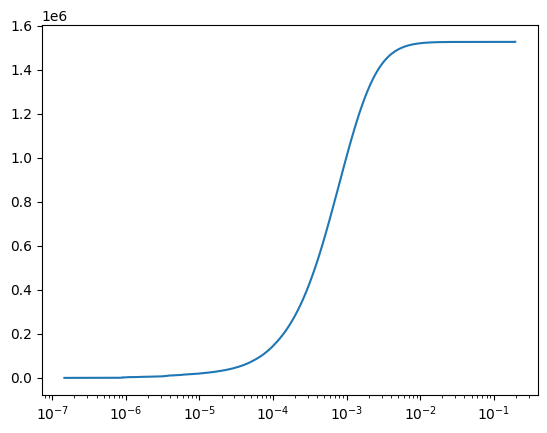

In [42]:
moves = np.array(results)
moves = moves[moves > 0]
moves_sorted = np.sort(moves)

n = len(moves_sorted)
# 1, 2, 3, ..., n  (cumulative counts)
cum_counts = np.arange(1, n + 1)
plt.xscale('log')
plt.step(moves_sorted, cum_counts, where="post")

(array([1.6000e+01, 1.6000e+01, 4.3000e+01, 1.7000e+01, 2.0000e+01,
        2.9000e+01, 2.2000e+01, 2.6000e+01, 2.6000e+01, 4.2000e+01,
        3.7000e+01, 5.0000e+01, 1.3540e+03, 1.2150e+03, 7.4000e+02,
        1.3000e+02, 7.4700e+02, 4.7200e+02, 4.3300e+02, 5.8100e+02,
        5.9300e+02, 6.4100e+02, 2.5550e+03, 1.4240e+03, 1.2060e+03,
        1.0620e+03, 2.0680e+03, 1.4670e+03, 1.3010e+03, 1.5850e+03,
        2.0990e+03, 2.1850e+03, 2.4910e+03, 2.9260e+03, 3.3810e+03,
        3.8280e+03, 4.6780e+03, 5.4390e+03, 6.0870e+03, 7.3490e+03,
        8.8770e+03, 1.0495e+04, 1.1622e+04, 1.3722e+04, 1.6032e+04,
        1.8607e+04, 2.1489e+04, 2.3622e+04, 2.6943e+04, 3.0853e+04,
        3.4741e+04, 3.9626e+04, 4.3945e+04, 4.9799e+04, 5.4728e+04,
        5.9873e+04, 6.4924e+04, 6.9717e+04, 7.2868e+04, 7.5899e+04,
        7.6384e+04, 7.6894e+04, 7.5201e+04, 7.1767e+04, 6.7220e+04,
        6.1188e+04, 5.5206e+04, 4.7581e+04, 4.0691e+04, 3.3115e+04,
        2.7287e+04, 2.1712e+04, 1.6578e+04, 1.28

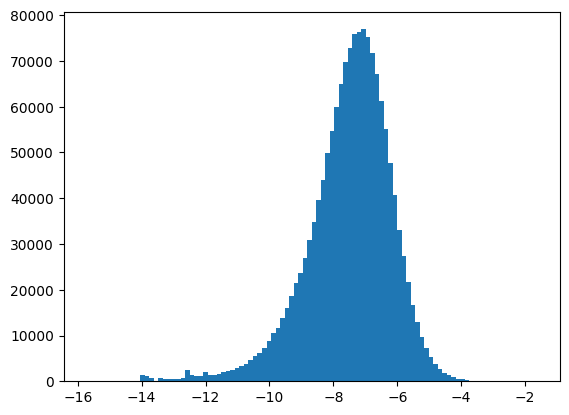

In [43]:
log_moves = np.log(moves)
plt.hist(log_moves, bins=100)

In [45]:
from scipy.stats import skew, kurtosis
mean = log_moves.mean()
std = log_moves.std()
skewness = skew(log_moves)
excess_kurt = kurtosis(log_moves)  # 0 for perfect normal

print("mean(log move):", mean)
print("std(log move):", std)
print("skew(log move):", skewness)
print("excess kurtosis(log move):", excess_kurt)

mean(log move): -7.5092027666530115
std(log move): 1.3321456197808175
skew(log move): -0.9843252455848457
excess kurtosis(log move): 2.3747741408781735


In [95]:
import numpy as np
import pandas as pd

def detect_exhaustion_trends(df, horizon=20, threshold=0.002, price_col="close"):
    """
    Detect trends using your 'no new extreme for H bars' definition.

    A bullish trend ends at bar i if, over the next `horizon` bars,
    no close exceeds close[i] * (1 + threshold).
    A bearish trend ends at bar i if, over the next `horizon` bars,
    no close goes below close[i] * (1 - threshold).

    When a trend ends, we:
      - record one % move for that trend (from start to end),
      - flip direction,
      - start the next trend at the next bar.

    Parameters
    ----------
    df : pd.DataFrame
        Must have a column `price_col` and a DateTimeIndex (or any index).
    horizon : int
        Lookahead window in bars (e.g. 20).
    threshold : float
        Fractional threshold for "meaningful" new extreme, e.g. 0.002 = 0.2%.
    price_col : str
        Column name for prices (typically 'close').

    Returns
    -------
    trends_df : pd.DataFrame
        One row per detected trend, with:
        - direction  (+1 bullish, -1 bearish)
        - start_idx, end_idx
        - start_time, end_time
        - start_price, end_price
        - move_pct (signed)
        - abs_move_pct (abs of move_pct)
    """
    prices = df[price_col].to_numpy(dtype=float)
    n = len(prices)
    if n < 2:
        return pd.DataFrame()

    # --- choose an initial direction from the first non-flat move ---
    direction = 0
    for k in range(1, n):
        if prices[k] > prices[k-1]:
            direction = 1   # bullish
            break
        elif prices[k] < prices[k-1]:
            direction = -1  # bearish
            break

    if direction == 0:
        # all prices equal; no trends
        return pd.DataFrame()

    trends = []
    start_idx = 0
    i = start_idx

    while start_idx < n - 1 and i < n:
        # We are currently in a trend with given `direction`
        while True:
            end_forward = min(n, i + 1 + horizon)
            fwd = prices[i + 1:end_forward]

            # Decide whether the trend can continue
            if direction == 1:  # bullish
                if len(fwd) > 0 and fwd.max() > prices[i] * (1 + threshold):
                    # There *will* be a higher close within H bars -> trend continues
                    i += 1
                    if i >= n - 1:
                        # End trend at last bar
                        end_idx = n - 1
                        move_pct = (prices[end_idx] - prices[start_idx]) / prices[start_idx]
                        trends.append({
                            "direction": direction,
                            "start_idx": start_idx,
                            "end_idx": end_idx,
                            "start_time": df.index[start_idx],
                            "end_time": df.index[end_idx],
                            "start_price": prices[start_idx],
                            "end_price": prices[end_idx],
                            "move_pct": move_pct,
                            "abs_move_pct": abs(move_pct),
                        })
                        start_idx = n  # exit outer loop
                        break
                    continue
                else:
                    # No new high beyond this close within H bars -> bullish trend ends here
                    end_idx = i
                    move_pct = (prices[end_idx] - prices[start_idx]) / prices[start_idx]

            else:  # direction == -1, bearish
                if len(fwd) > 0 and fwd.min() < prices[i] * (1 - threshold):
                    # There *will* be a lower close within H bars -> trend continues
                    i += 1
                    if i >= n - 1:
                        # End trend at last bar
                            # End trend at last bar
                        end_idx = n - 1
                        move_pct = (prices[start_idx] - prices[end_idx]) / prices[start_idx]
                        trends.append({
                            "direction": direction,
                            "start_idx": start_idx,
                            "end_idx": end_idx,
                            "start_time": df.index[start_idx],
                            "end_time": df.index[end_idx],
                            "start_price": prices[start_idx],
                            "end_price": prices[end_idx],
                            "move_pct": move_pct,
                            "abs_move_pct": abs(move_pct),
                        })
                        start_idx = n  # exit outer loop
                        break
                    continue
                else:
                    # No new low beyond this close within H bars -> bearish trend ends here
                    end_idx = i
                    move_pct = (prices[start_idx] - prices[end_idx]) / prices[start_idx]

            # Record the finished trend
            trends.append({
                "direction": direction,
                "start_idx": start_idx,
                "end_idx": end_idx,
                "start_time": df.index[start_idx],
                "end_time": df.index[end_idx],
                "start_price": prices[start_idx],
                "end_price": prices[end_idx],
                "move_pct": move_pct,
                "abs_move_pct": abs(move_pct),
            })

            # Start the next trend
            start_idx = end_idx + 1
            i = start_idx
            direction = -direction  # flip trend direction
            break  # break inner while, continue outer

    trends_df = pd.DataFrame(trends)
    return trends_df

trends_df = detect_exhaustion_trends(df, horizon=20, threshold=0.002, price_col="close")

# One value per trend (absolute percentage move)
results = trends_df["abs_move_pct"].to_numpy()

# If you want signed moves instead:
signed_results = trends_df["move_pct"].to_numpy()


In [104]:
tr = trends_df.dropna(subset=["move_pct", "abs_move_pct"]).copy()

# Log of size (avoid 0)
eps = 1e-12
tr["log_abs_move"] = np.log(tr["abs_move_pct"] + eps)
abs_moves = tr["abs_move_pct"].to_numpy()
log_abs_moves = tr["log_abs_move"].to_numpy()

prev_log = log_abs_moves[:-1]
next_log = log_abs_moves[1:]

corr_log_size = np.corrcoef(prev_log, next_log)[0, 1]
print("Corr(log |move|_t, log |move|_(t+1)):", corr_log_size)

Corr(log |move|_t, log |move|_(t+1)): 0.29829667615140787


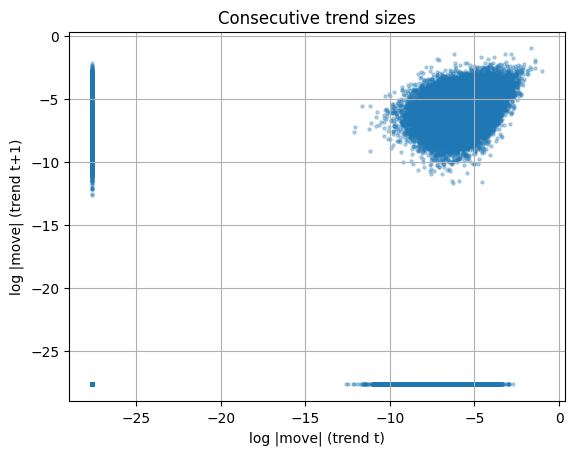

In [105]:
plt.scatter(prev_log, next_log, s=5, alpha=0.3)
plt.xlabel("log |move| (trend t)")
plt.ylabel("log |move| (trend t+1)")
plt.title("Consecutive trend sizes")
plt.grid(True)
plt.show()

In [106]:
moves = tr["move_pct"].to_numpy()
dirs = tr["direction"].to_numpy()  # +1 for bull, -1 for bear

prev_move = moves[:-1]
next_move = moves[1:]

# Simple signed correlation
corr_signed = np.corrcoef(prev_move, next_move)[0, 1]
print("Corr(move_t, move_(t+1)):", corr_signed)


Corr(move_t, move_(t+1)): 0.4850609503883096


In [107]:
prev_dir = dirs[:-1]
next_dir = dirs[1:]

# Direction relationship
same_dir = prev_dir * next_dir > 0   # both +1 or both -1
flip_dir = prev_dir * next_dir < 0   # +1 then -1 or -1 then +1

# Sizes of NEXT trend conditional on previous
next_size_same = np.abs(next_move[same_dir])
next_size_flip = np.abs(next_move[flip_dir])

print("Mean |move_(t+1)| when direction stays same:", next_size_same.mean())
print("Mean |move_(t+1)| when direction flips:", next_size_flip.mean())

Mean |move_(t+1)| when direction stays same: nan
Mean |move_(t+1)| when direction flips: 0.0003751760763749653


C:\Users\shuce\AppData\Local\Temp\ipykernel_11412\101418403.py:12: RuntimeWarning: Mean of empty slice.
  print("Mean |move_(t+1)| when direction stays same:", next_size_same.mean())
C:\Users\shuce\PycharmProjects\Quant\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


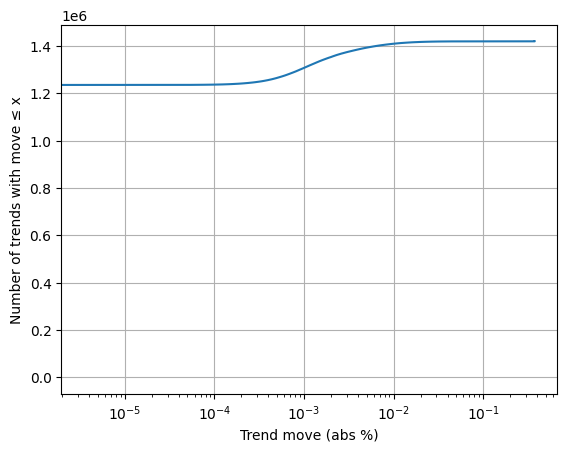

In [96]:
moves = results  # abs_move_pct
moves_sorted = np.sort(moves)
cum_counts = np.arange(1, len(moves_sorted) + 1)

plt.step(moves_sorted, cum_counts, where="post")
plt.xscale("log")
plt.xlabel("Trend move (abs %)")
plt.ylabel("Number of trends with move ≤ x")
plt.grid(True)
plt.show()

In [97]:
moves_sorted = moves_sorted[moves_sorted > 0]

mean(log move): -6.541013064766043
std(log move): 1.1391426991812685
skew(log move): 0.182039231053667
excess kurtosis(log move): 0.22334475570978585


(array([2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 1.2000e+01,
        5.0000e+00, 1.5000e+01, 3.3000e+01, 4.3000e+01, 7.8000e+01,
        1.1600e+02, 1.9700e+02, 3.1100e+02, 4.6400e+02, 7.1900e+02,
        1.1970e+03, 1.8440e+03, 2.7560e+03, 3.9600e+03, 5.7740e+03,
        8.0920e+03, 1.0874e+04, 1.3460e+04, 1.5504e+04, 1.6524e+04,
        1.6190e+04, 1.4652e+04, 1.3198e+04, 1.1005e+04, 9.4310e+03,
        8.4730e+03, 7.0740e+03, 6.0120e+03, 4.7170e+03, 3.7850e+03,
        2.7440e+03, 1.9500e+03, 1.3310e+03, 8.1800e+02, 4.7200e+02,
        2.4000e+02, 1.3500e+02, 7.6000e+01, 4.6000e+01, 1.9000e+01,
        5.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-12.56598584, -12.33420616, -12.10242647, -11.87064679,
        -11.63886711, -11.40708742, -11.17530774, -10.94352806,
        -10.71174837, -10.47996869, -10.248189  , -10.01640932,
         -9.78462964,  -9.55284995,  -9.32107027,  -9.08929059,
         -8.8575109 ,  -8.62573122,  -8.39395154,  -8.16217185

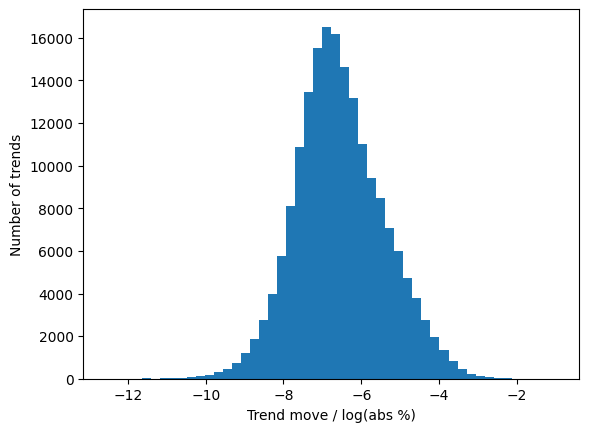

In [103]:
log_moves = np.log(moves_sorted)
mean = log_moves.mean()
std = log_moves.std()
skewness = skew(log_moves)
excess_kurt = kurtosis(log_moves)  # 0 for perfect normal

print("mean(log move):", mean)
print("std(log move):", std)
print("skew(log move):", skewness)
print("excess kurtosis(log move):", excess_kurt)
plt.ylabel("Number of trends")
plt.xlabel("Trend move / log(abs %)")
plt.hist(log_moves, bins=50)

In [85]:
# ema_strat = EMACrossOver(df.copy())
# ema_strat.backtest()
mr_strat = MeanReversion(df.copy())
mr_strat.backtest(500)

100%|██████████| 3068140/3068140 [00:03<00:00, 957623.83it/s]

129543.22585471091


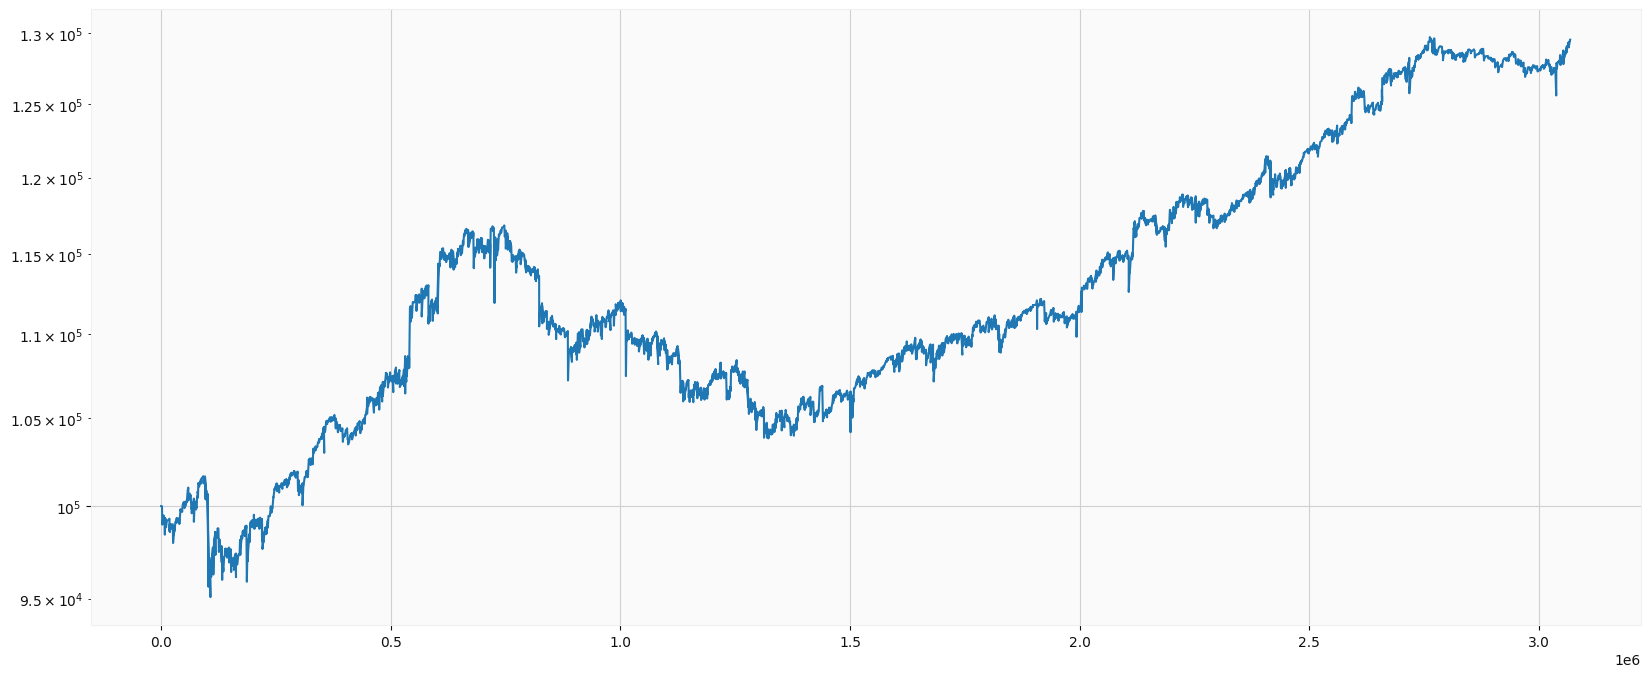

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(mr_strat.broker.equity_curve)
plt.yscale('log')
plt.show()

In [80]:
len(mr_strat.broker.logs)

7590